# Real-World Case Studies - Equity Options

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

## Load the Libs we need

In [1]:
# import Lib
import pandas as pd
import datetime as dt
import pytz
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as si
import math

# import module
from datetime import datetime, timezone
from datetime import date, time
from math import trunc
from scipy.stats import norm

## Introduction to Real-World Equity Options Case Studies

In [2]:
def equity_option_pricing(S, K, T, r, q, vol, option_type="call"):
    # S: Current stock price (e.g., AAPL's current price)
    # K: Option strike price
    # T: Time to expiration
    # r: Risk-free interest rate
    # q: Continuous dividend yield
    # vol: Volatility of the underlying stock
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    if option_type == "call":
        option_price = (S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    elif option_type == "put":
        option_price = (K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0))
    return option_price

# Example usage
S = 150  # Current AAPL stock price
K = 160  # Strike Price
T = 0.5  # Time to expiration in years
r = 0.02  # Risk-free interest rate
q = 0.005  # Dividend yield for AAPL
vol = 0.20  # Volatility of AAPL stock

call_price = equity_option_pricing(S, K, T, r, q, vol, option_type="call")
put_price = equity_option_pricing(S, K, T, r, q, vol, option_type="put")

print(f"The price of the European Call Option for AAPL is: {call_price:.4f}")
print(f"The price of the European Put Option for AAPL is: {put_price:.4f}")


The price of the European Call Option for AAPL is: 4.9863
The price of the European Put Option for AAPL is: 13.7688


## Equity Options Hedging Strategies

#### Case Study: Hedging AAPL Stocks with a “collar” strategy

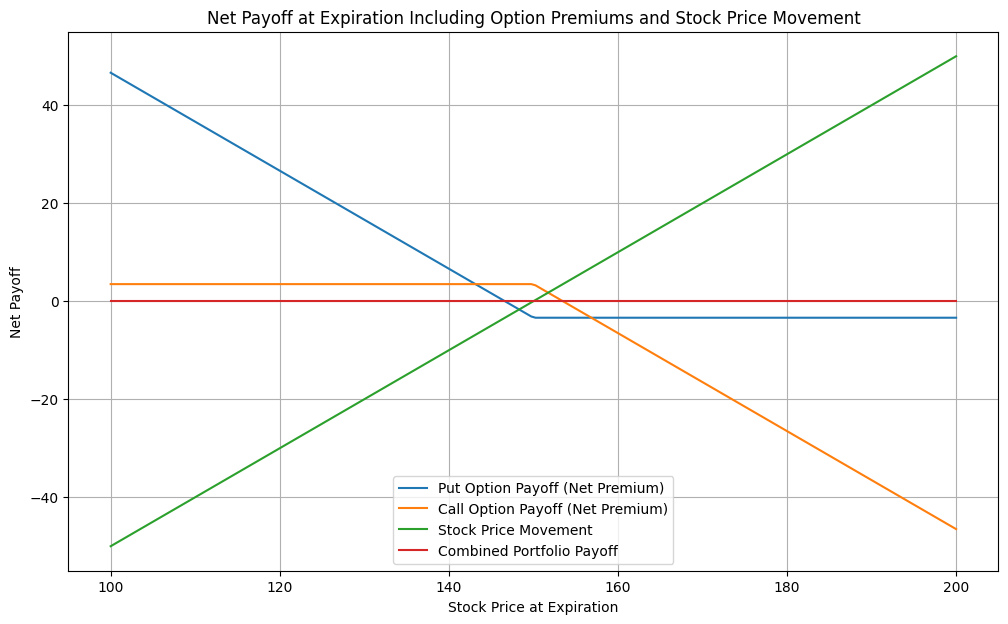

In [3]:
# Parameters
S0 = 150  # initial stock price
K = 150  # strike price of the put and call options
T = 30/365  # time to expiration (30 days)
r = 0.01  # risk-free rate
sigma = 0.2  # volatility
dividend = 0.82  # dividend amount

# Black-Scholes pricing model for options
def black_scholes(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        price = S * si.norm.cdf(d1) - K * np.exp(-r * T) * si.norm.cdf(d2)
    else:
        price = K * np.exp(-r * T) * si.norm.cdf(-d2) - S * si.norm.cdf(-d1)
    return price

# Initial option premiums
put_premium = black_scholes(S0, K, T, r, sigma, 'put')
call_premium = black_scholes(S0, K, T, r, sigma, 'call')

# Range of stock prices at expiration
final_stock_prices = np.linspace(max(0, S0 - 50), S0 + 50, 200)

# Payoff functions including premiums
def put_payoff(S, K, premium):
    return np.maximum(K - S, 0) - premium

def call_payoff(S, K, premium):
    return np.maximum(S - K, 0) - premium

put_option_payoffs = put_payoff(final_stock_prices, K, put_premium)
call_option_payoffs = call_payoff(final_stock_prices, K, call_premium)  # Assuming selling calls

# Stock movement effect
stock_movement = final_stock_prices - S0

# Combined portfolio payoff
combined_portfolio_payoffs = put_option_payoffs - call_option_payoffs + stock_movement

# Plotting
plt.figure(figsize=(12, 7))
plt.plot(final_stock_prices, put_option_payoffs, label='Put Option Payoff (Net Premium)')
plt.plot(final_stock_prices, -call_option_payoffs, label='Call Option Payoff (Net Premium)')
plt.plot(final_stock_prices, stock_movement, label='Stock Price Movement')
plt.plot(final_stock_prices, combined_portfolio_payoffs, label='Combined Portfolio Payoff')
plt.title('Net Payoff at Expiration Including Option Premiums and Stock Price Movement')
plt.xlabel('Stock Price at Expiration')
plt.ylabel('Net Payoff')
plt.legend()
plt.grid(True)
plt.show()

#### Delta Hedging Simulation

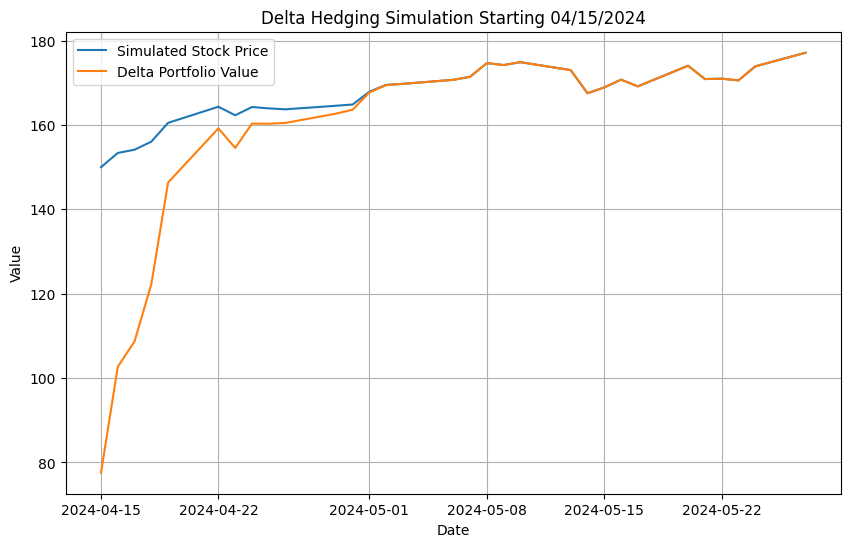

In [4]:
def black_scholes(S, K, T, r, sigma, option_type='call'):
    """Calculate the Black-Scholes option price for a call/put, handling edge cases."""
    if T <= 0 or sigma == 0:
        # Handle cases where there is no time left or no volatility
        if option_type == 'call':
            return max(S - K, 0)
        else:
            return max(K - S, 0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

def delta(S, K, T, r, sigma, option_type='call'):
    """Calculate the Black-Scholes Delta of a call/put option, with edge case handling."""
    if T <= 0 or sigma == 0:
        # Delta is effectively 0 as the option price doesn't change with the stock price
        return 0 if option_type == 'put' else 1 if S > K else 0
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1) if option_type == 'call' else -norm.cdf(-d1)

# Fixed value date
value_date = pd.Timestamp('2024-04-15')

# Simulate stock price path and perform delta hedging
np.random.seed(0)
initial_price = 150
dates = pd.date_range(start=value_date, periods=31, freq='B')
prices = [initial_price]
sigma = 0.2
K = initial_price
r = 0.01
T = 30 / 365

for i in range(1, len(dates)):
    z = np.random.normal()
    dt = 1 / 252  # Time step in years
    drift = (r - 0.5 * sigma**2) * dt
    diffusion = sigma * np.sqrt(dt) * z
    prices.append(prices[-1] * np.exp(drift + diffusion))

# Implementing Delta Hedging
hedge_positions = []
stock_positions = []
delta_portfolio = []

for i, price in enumerate(prices):
    remaining_T = max(T - i / 252, 0)
    current_delta = delta(price, K, remaining_T, r, sigma, 'call')
    stock_positions.append(-current_delta)  # Adjust stock position to hedge
    delta_value = current_delta * price
    delta_portfolio.append(delta_value)
    hedge_positions.append(price * current_delta - delta_value)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(dates, prices, label='Simulated Stock Price')
plt.plot(dates, delta_portfolio, label='Delta Portfolio Value')
plt.title('Delta Hedging Simulation Starting 04/15/2024')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


## Speculative Trading in Equity Options

In [5]:
# Pricing function for a dividend-paying stock
def equity_option_pricing(S, K, T, r, q, vol, option_type="call"):
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    
    if option_type == "call":
        return (S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    elif option_type == "put":
        return (K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0))

# Given parameters (make sure to set them based on your needs)
S = 150  # Current stock price of AAPL
K = 155  # Strike Price
T = 0.5  # Time to expiration in years
r = 0.02  # Risk-free interest rate
q = 0.01  # Dividend yield for AAPL
vol = 0.20  # Volatility

call_price = equity_option_pricing(S, K, T, r, q, vol, option_type="call")

# Assuming the AAPL stock price goes up to 155
S_new = 155

# New call price
new_call_price = equity_option_pricing(S_new, K, T, r, q, vol, option_type="call")

# Profit from the long call position
profit = new_call_price - call_price

print(f"The profit from the long call position on AAPL is: {profit:.4f}")


The profit from the long call position on AAPL is: 2.4693


## Risk Management in Equity Options

In [6]:
import numpy as np
import scipy.stats as si

# Pricing function for a dividend-paying stock
def equity_option_pricing(S, K, T, r, q, vol, option_type="call"):
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    
    if option_type == "call":
        return (S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    elif option_type == "put":
        return (K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0))

# Given parameters (make sure to set them based on your needs)
S = 150  # Current stock price of AAPL
K = 155  # Strike Price
T = 0.5  # Time to expiration in years
r = 0.02  # Risk-free interest rate
q = 0.01  # Dividend yield for AAPL
vol = 0.20  # Volatility

call_price = equity_option_pricing(S, K, T, r, q, vol, option_type="call")

# Assume a portfolio of 1000 European Call Options
portfolio_size = 1000
portfolio_value = portfolio_size * call_price

# Assume a confidence level of 99%
alpha = 0.99

# Simplified VaR Calculation for Options Portfolio 
VaR = portfolio_value * (1 - si.norm.cdf(vol * np.sqrt(T), 0.0, 1.0))

print(f"The Value at Risk (VaR) of the AAPL call options portfolio, considering dividends, is: ${VaR:.2f}")


The Value at Risk (VaR) of the AAPL call options portfolio, considering dividends, is: $2925.84


## Implementing Pricing and Valuation Models in Equity Options

In [7]:
# Pricing function for a dividend-paying stock
def equity_option_pricing(S, K, T, r, q, vol, option_type="call"):
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    
    if option_type == "call":
        return (S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    elif option_type == "put":
        return (K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0))

# Given parameters (these should be set based on your needs or prior data)
S = 150  # Current stock price of AAPL
K = 155  # Strike Price
T = 0.5  # Time to expiration in years
r = 0.02  # Risk-free interest rate
q = 0.01  # Dividend yield for AAPL
vol = 0.20  # Original Volatility

# Assuming a new recalibrated volatility
new_vol = 0.18

# New call price with recalibrated volatility
new_call_price_recalibrated = equity_option_pricing(S, K, T, r, q, new_vol, option_type="call")

print(f"The price of the AAPL European Call Option with recalibrated volatility, considering dividends, is: ${new_call_price_recalibrated:.2f}")


The price of the AAPL European Call Option with recalibrated volatility, considering dividends, is: $5.76
